# **Sensor time-series of aircraft engines**
### Can one predict when an engine breaks down?

**Ruthger Righart**

Email: <font color="blue">rrighart@googlemail.com</font>

Blog website: https://rrighart.github.io

Hire-me remotely, for short / long projects: https://www.rrighart.com



**1. Introduction**

Can one predict when an engine or device breaks down?

This seems a pure engineering question. But nowadays it is also a data science question. 
More concretely, it is an important question everywhere engines and devices use data to guide maintenance, such as aircraft engines<font color="blue"><sup>1</sup></font>, windturbine engines<font color="blue"><sup>2</sup></font>, and rotating machinery<font color="blue"><sup>3</sup></font>. With regards to human safety and logistic planning, it is not a good idea to just wait until an engine breaks down. It is essential to *proactively* plan maintenance to avoid costly downtime. 

Proactive planning is enabled by *multiple sensor technologies* that provide powerful data about the state of machines and devices. Sensors include data such as temperature, fan and core speed, static pressure etc. Can we use these data to predict within certain margins how long an aircraft engine will be functioning without failure? And if so, how to do it?

This is the question the concept of *remaining useful life (RUL)* attempts to answer. It aims to estimate *the remaining time an item, component, or system is able to function in accordance with its intended purpose before warranting replacement*. The present blog shows how to use deep learning in Python Keras to predict the RUL. It is meant to provide an example case study, not an exhaustive and ultimate solution. 

There is a lack of real data to answer this question. However, data simulations have been made and provide a unique resource. One such a fascinating simulation is provided by the C-MAPSS data<font color="blue"><sup>1</sup></font>. It provides train data that show sensor-based time-series until the timepoint the engine breaks down. In contrast, the test data constitute of sensor-based time-series a "random" time before the endpoint. The key aim is to estimate the RUL of the testset, that is, how much time is left after the last recorded time-point.

**2. Modules**


In [1]:
import os
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False
import pandas as pd
import numpy as np
np.random.seed(1337)
import requests, zipfile, io
from IPython.display import Image
import matplotlib as mpl
import matplotlib.pyplot as plt
from pandas import read_csv
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.stats import norm
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
import scipy.stats
from keras.utils import plot_model

d:\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
d:\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
d:\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
d:\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is depr

The following settings will be used to avoid exponential values in output or tables and to display 50 rows maximum:

In [2]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.display.max_rows=50

**3. Sketch of the question**

A simplified lineplot illustrates best the question at hand. Given a fictive temperature sensor, for which we have 8 cycles, are we able to predict the remaining cycles? 

The kind of questions that can be addressed for such a time-serie: 
* Can we forecast the temperature of the future time-points?
* Can we predict how long the time-serie continues until a pre-defined event happens?

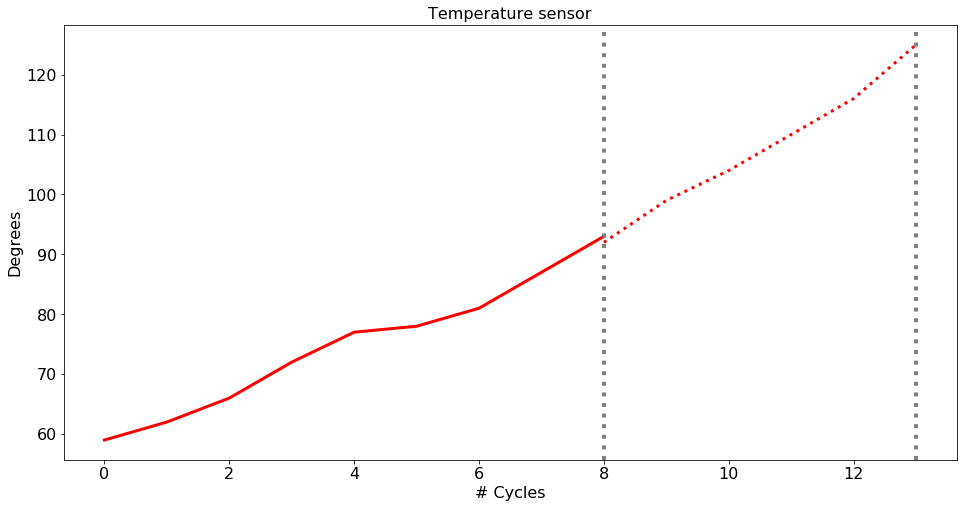

In [3]:
def normal_noise(input_array):
    input_array=input_array+np.random.normal(loc = 60.0, scale = 1.0, size = len(input_array))
    return input_array.astype('int')

def plot_predictive_lines():
    """A line with Ax+B+random integer in the range(min_value,max_value) format
    arguments:
    A
    B
    min_value
    max_value
    line_length
    predict_length
    """
    
    a=[0,3,7,14,17,21,22,27,32]
    A=normal_noise(a)
    B=[92,99,104,110,116,125]
    
    C = np.append(np.repeat(np.nan, len(A)-1), B)
    plt.figure(figsize = (16, 8))
    plt.plot(A, color='red', linewidth=3)
    plt.plot(C, 'r:', linewidth=3)
    plt.axvline(x=len(A)-1, color='grey', linestyle=':', linewidth=4)
    plt.axvline(x=len(C)-1, color='grey', linestyle=':', linewidth=4)
    plt.title('Temperature sensor', fontsize=16)
    plt.xlabel('# Cycles', fontsize=16)
    plt.ylabel('Degrees', fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.show()    
    
plot_predictive_lines()

In [4]:
#a=[60,63,67,74,77,81,82,87,92]
a=[0,3,7,14,17,21,22,27,32]
A=normal_noise(a)

In [5]:
def sample_pdf_cdf():
    data = scipy.stats.norm.rvs(size=100000, loc=3, scale=1.5)
    hist = np.histogram(data, bins=100)
    hist_dist = scipy.stats.rv_histogram(hist)
    X = np.linspace(-5.0, 5.0, 100)
    plt.title("PDF from Template")
    plt.hist(data, density=True, bins=100)
    plt.plot(X, hist_dist.pdf(X), label='PDF')
    plt.plot(X, hist_dist.cdf(X), label='CDF')
    plt.show()

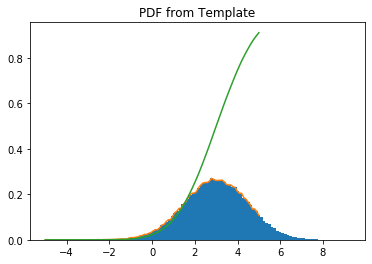

In [6]:
sample_pdf_cdf()


In [7]:
help(norm.pdf)

Help on method pdf in module scipy.stats._distn_infrastructure:

pdf(x, *args, **kwds) method of scipy.stats._continuous_distns.norm_gen instance
    Probability density function at x of the given RV.
    
    Parameters
    ----------
    x : array_like
        quantiles
    arg1, arg2, arg3,... : array_like
        The shape parameter(s) for the distribution (see docstring of the
        instance object for more information)
    loc : array_like, optional
        location parameter (default=0)
    scale : array_like, optional
        scale parameter (default=1)
    
    Returns
    -------
    pdf : ndarray
        Probability density function evaluated at x



**4. Loading the data**

The data concerns the C-MAPSS set and can be found at: https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/ where it is under **"Turbofan Engine Degradation Simulation Data Set"** providing a ZIP file. The one that we are using for the current purpose is **FD001**, but the reader is encouraged to use the others as well (more data usually means better prediction power).
It can be downloaded either manually or using the script below that downloads the content of the ZIP file from the requested URL in your homedirectory<font color="blue"><sup>4</sup></font>  .

Now that the files are in your home directory, you can read them using Pandas **read_csv**. We will load a train- and testset, as well as a RUL set. RUL contains the true values for remaining useful life to which we are going to compare our predicted values in the testset.

In [8]:
train = pd.read_csv('train_FD001.txt', parse_dates=False, delimiter=" ", decimal=".", header=None)
test = pd.read_csv('test_FD001.txt', parse_dates=False, delimiter=" ", decimal=".", header=None)
RUL = pd.read_csv('RUL_FD001.txt', parse_dates=False, decimal=".", header=None)

**5. Missing values**

First, we need to drop the two last columns since they actually only have missing values. This is probably due to trailing tab characters in the csv file. At any time, it is always better to verify this as the owners of the data may have edited this at any moment. The following code prints the proportion of missing values for each column in the train- and testset:

In [9]:
tableNA = pd.concat([train.isnull().sum(), test.isnull().sum()], axis=1)
tableNA.columns = ['train', 'test']
tableNA

,train,test
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0


We will first drop the columns that consisted of missing values:

In [10]:
train.drop(train.columns[[-1,-2]], axis=1, inplace=True)
test.drop(test.columns[[-1,-2]], axis=1, inplace=True)

And then we will give names to all columns:

In [11]:
cols = ['unit', 'cycles', 'op_setting1', 'op_setting2', 'op_setting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
train.columns = cols
test.columns = cols

And so the train- and testset look as follows:

In [12]:
train.head()

,unit,cycles,op_setting1,op_setting2,op_setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.001,-0.000,100.000,518.670,641.820,1589.700,1400.600,14.620,...,521.660,2388.020,8138.620,8.419,0.030,392,2388,100.000,39.060,23.419
1,1,2,0.002,-0.000,100.000,518.670,642.150,1591.820,1403.140,14.620,...,522.280,2388.070,8131.490,8.432,0.030,392,2388,100.000,39.000,23.424
2,1,3,-0.004,0.000,100.000,518.670,642.350,1587.990,1404.200,14.620,...,522.420,2388.030,8133.230,8.418,0.030,390,2388,100.000,38.950,23.344
3,1,4,0.001,0.000,100.000,518.670,642.350,1582.790,1401.870,14.620,...,522.860,2388.080,8133.830,8.368,0.030,392,2388,100.000,38.880,23.374
4,1,5,-0.002,-0.000,100.000,518.670,642.370,1582.850,1406.220,14.620,...,522.190,2388.040,8133.800,8.429,0.030,393,2388,100.000,38.900,23.404


In [13]:
test.head()

,unit,cycles,op_setting1,op_setting2,op_setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,0.002,0.000,100.000,518.670,643.020,1585.290,1398.210,14.620,...,521.720,2388.030,8125.550,8.405,0.030,392,2388,100.000,38.860,23.373
1,1,2,-0.003,-0.000,100.000,518.670,641.710,1588.450,1395.420,14.620,...,522.160,2388.060,8139.620,8.380,0.030,393,2388,100.000,39.020,23.392
2,1,3,0.000,0.000,100.000,518.670,642.460,1586.940,1401.340,14.620,...,521.970,2388.030,8130.100,8.444,0.030,393,2388,100.000,39.080,23.417
3,1,4,0.004,0.000,100.000,518.670,642.440,1584.120,1406.420,14.620,...,521.380,2388.050,8132.900,8.392,0.030,391,2388,100.000,39.000,23.374
4,1,5,0.001,0.000,100.000,518.670,642.510,1587.190,1401.920,14.620,...,522.150,2388.030,8129.540,8.403,0.030,390,2388,100.000,38.990,23.413


And the RUL data look as follows, in short meaning that the remaining useful life for the first unit was 112 cycles, the second unit 98 cycles, etc.

In [14]:
RUL.head()

,0
0,112
1,98
2,69
3,82
4,91


**6. Outliers and flat lines**

To know if there are outliers (extreme values) in the data, we could use descriptive statistics, **train.describe().transpose()**, and see if the min. and max. values are far away from the central tendency. As we can see below, this is not the case for any of the sensors.

However, if we look carefully we can see something else that is quite remarkable: there are several sensors where the min. and max. values are identical, and where the standard deviation (std) is zero. In time-series, this is called a *flat line*, which means there is no activity, possibly caused by sensor malfunctioning. 

In [15]:
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
unit,20631.000,51.507,29.228,1.000,26.000,52.000,77.000,100.000
cycles,20631.000,108.808,68.881,1.000,52.000,104.000,156.000,362.000
op_setting1,20631.000,-0.000,0.002,-0.009,-0.002,0.000,0.002,0.009
op_setting2,20631.000,0.000,0.000,-0.001,-0.000,0.000,0.000,0.001
op_setting3,20631.000,100.000,0.000,100.000,100.000,100.000,100.000,100.000
s1,20631.000,518.670,0.000,518.670,518.670,518.670,518.670,518.670
s2,20631.000,642.681,0.500,641.210,642.325,642.640,643.000,644.530
s3,20631.000,1590.523,6.131,1571.040,1586.260,1590.100,1594.380,1616.910
s4,20631.000,1408.934,9.001,1382.250,1402.360,1408.040,1414.555,1441.490
s5,20631.000,14.620,0.000,14.620,14.620,14.620,14.620,14.620


The sensors s1, s5, s10, s16, s18, and s19 as well as op_setting 3, will for this reason be removed from further analyses:

In [16]:
train.drop(['s1', 's5', 's10', 's16', 's18', 's19', 'op_setting3'], axis=1, inplace=True)
test.drop(['s1', 's5', 's10', 's16', 's18', 's19', 'op_setting3'], axis=1, inplace=True)

The distribution of the columns looks as follows:

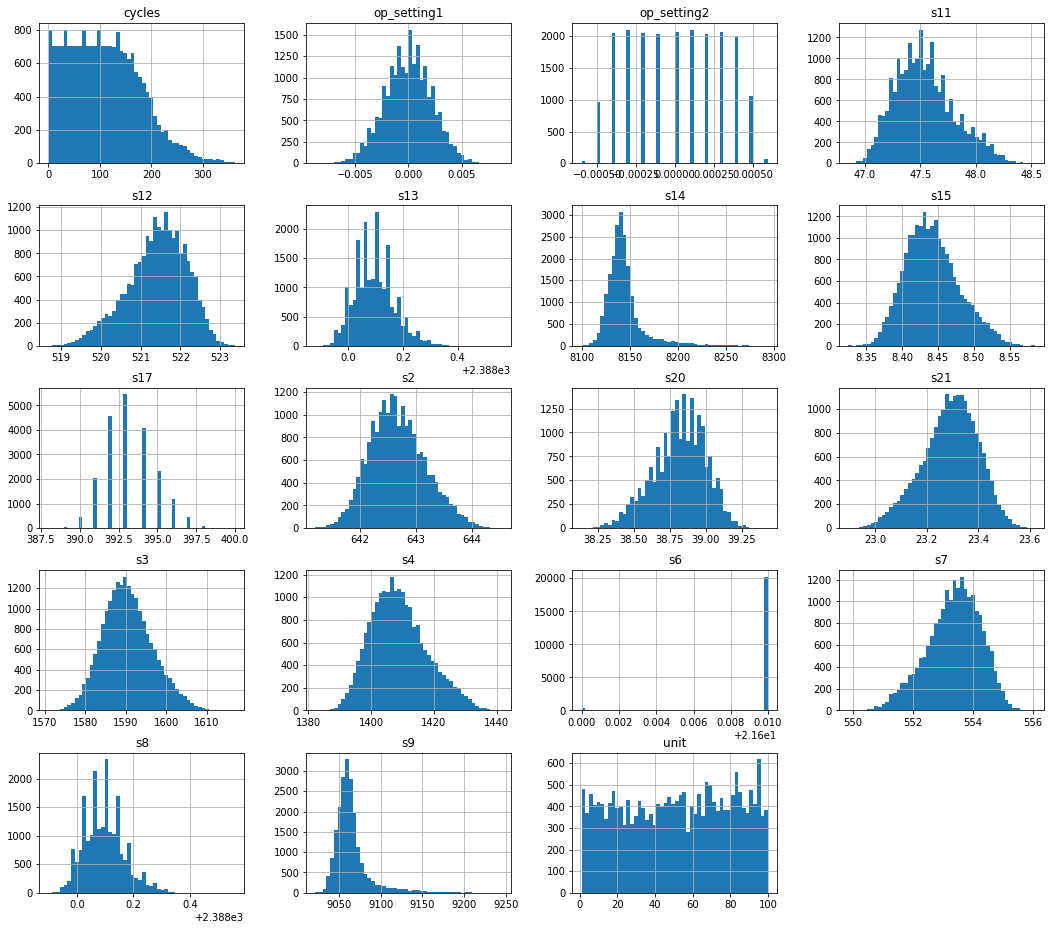

In [17]:
train.hist(bins=50, figsize=(18,16))
plt.show()

**7. Exploratory analyses of the max. number of cycles per unit**

Exploratory data analyses provide insight into the aircraft engines in action. For example, it would be good to have an idea of the maximum lifetime of the 100 different units. The barplots below show that there is a large variation across units regarding max. number of cycles, and that, as expected, the number of cycles is shorter for testset than trainset.

In [18]:
cyclestrain = train.groupby('unit', as_index=False)['cycles'].max()
cyclestest = test.groupby('unit', as_index=False)['cycles'].max()

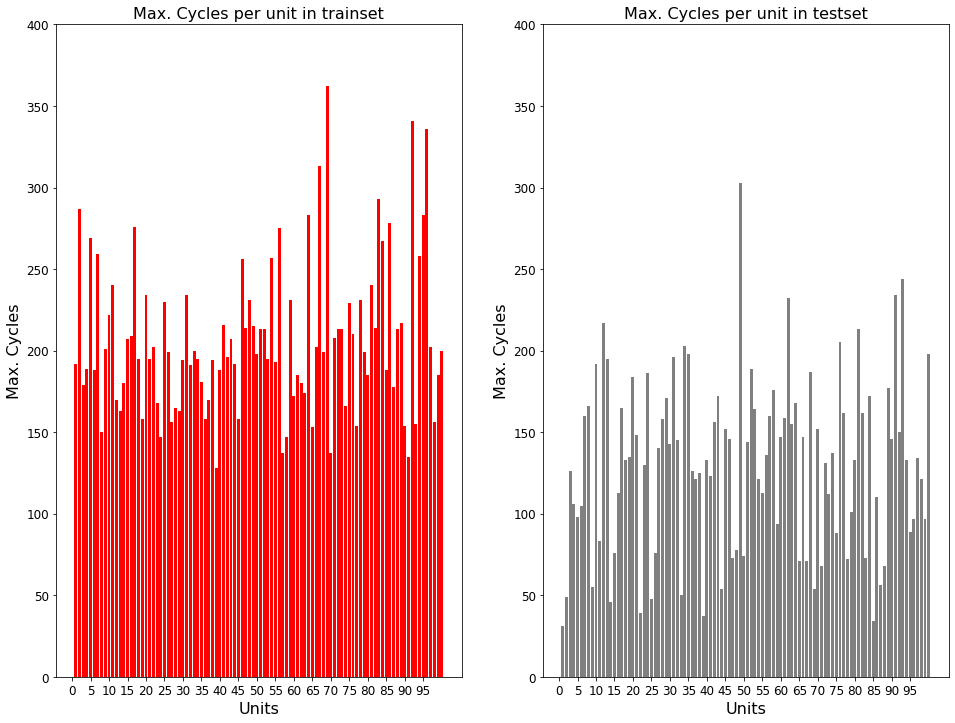

In [19]:
fig = plt.figure(figsize = (16,12))
fig.add_subplot(1,2,1)
bar_labels = list(cyclestrain['unit'])
bars = plt.bar(list(cyclestrain['unit']), cyclestrain['cycles'], color='red')
plt.ylim([0, 400])
plt.xlabel('Units', fontsize=16)
plt.ylabel('Max. Cycles', fontsize=16)
plt.title('Max. Cycles per unit in trainset', fontsize=16)
plt.xticks(np.arange(min(bar_labels)-1, max(bar_labels)-1, 5.0), fontsize=12)
plt.yticks(fontsize=12)
fig.add_subplot(1,2,2)
bars = plt.bar(list(cyclestest['unit']), cyclestest['cycles'], color='grey')
plt.ylim([0, 400])
plt.xlabel('Units', fontsize=16)
plt.ylabel('Max. Cycles', fontsize=16)
plt.title('Max. Cycles per unit in testset', fontsize=16)
plt.xticks(np.arange(min(bar_labels)-1, max(bar_labels)-1, 5.0), fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In fact, in machine learning it is considered good behavior to put apart the testset. So from now we do not touch or look at it anymore.

**8. Visualization of several sensors, for a particular unit**

The following visualizes different sensors of a particular unit. It gives a good impression that all sensors have a different range of values (as they measure different entities as speed, temperature), and that they do not all show an identical pattern or trend. In fact, some do increase in amplitude, while others decrease in amplitude over time. 

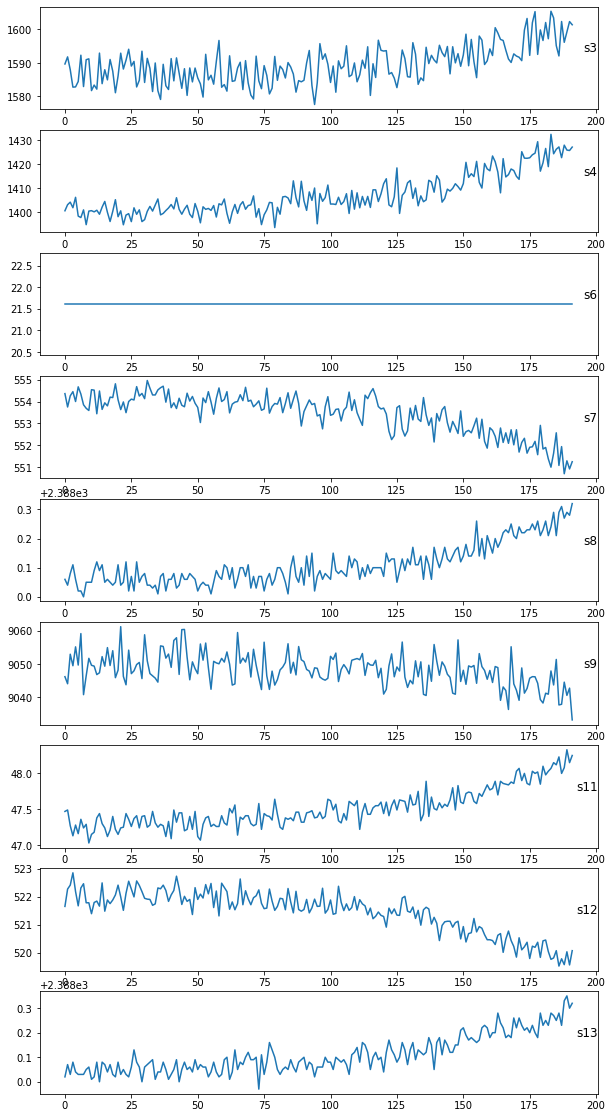

In [20]:
values = train[train.unit==1].values
groups = [5, 6, 7, 8, 9, 10, 11,12,13]
i = 1
plt.figure(figsize=(10,20))
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(train.columns[group], y=0.5, loc='right')
	i += 1
plt.show()

We can also show a single sensor for different engine units. This nicely illustrates across units that amplitudes decrease over time and seem to go to a certain minimum threshold of about 551-552. By the way: the data seem rather noisy and filtering may help at some point (not treated in this blog).

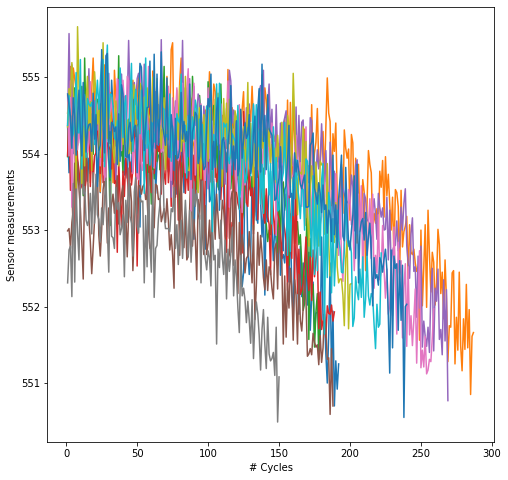

In [21]:
plt.figure(figsize = (8, 8))
plt.plot(train[train.unit==1].cycles, train[train.unit==1].s7)
plt.plot(train[train.unit==2].cycles, train[train.unit==2].s7)
plt.plot(train[train.unit==3].cycles, train[train.unit==3].s7)
plt.plot(train[train.unit==4].cycles, train[train.unit==4].s7)
plt.plot(train[train.unit==5].cycles, train[train.unit==5].s7)
plt.plot(train[train.unit==6].cycles, train[train.unit==6].s7)
plt.plot(train[train.unit==7].cycles, train[train.unit==7].s7)
plt.plot(train[train.unit==8].cycles, train[train.unit==8].s7)
plt.plot(train[train.unit==9].cycles, train[train.unit==9].s7)
plt.plot(train[train.unit==10].cycles, train[train.unit==10].s7)
plt.plot(train[train.unit==11].cycles, train[train.unit==11].s7)
plt.xlabel('# Cycles')
plt.ylabel('Sensor measurements')
plt.show()

So would it be possible that different units have a similar minimum and maximum value for single sensors? This would make sense if sensors started at a low amplitude (for ex. temperature) and went up to a high amplitude over time (or the other way around for other metrics). We could test this for ten units:

In [22]:
minb = train.groupby('unit', as_index=False).min().head(10)
maxb = train.groupby('unit', as_index=False).max().head(10)
mmtable = minb.append(maxb, ignore_index=True)

The following plot suggests that sensors follow a similar kind of pattern for different units. 

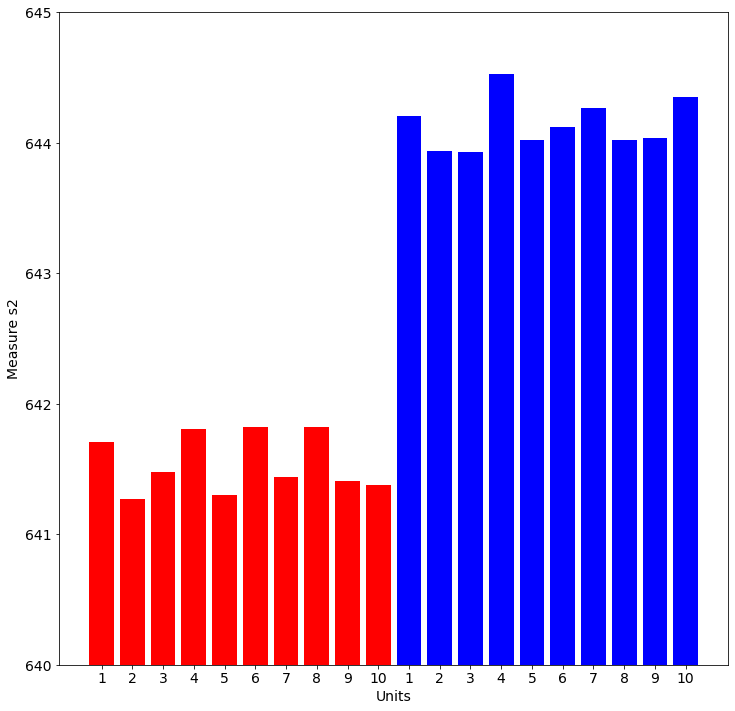

In [23]:
plt.figure(figsize = (12,12))
col = np.concatenate((np.repeat('red', 10), np.repeat('blue', 10)), axis=0)
bar_labels = list(mmtable['unit'])
x_pos = list(range(len(bar_labels)))
bars = plt.bar(x_pos, mmtable['s2'], color=col)
plt.ylim([640, 645])
plt.xlabel('Units', fontsize=14)
plt.ylabel('Measure s2', fontsize=14)
plt.xticks(x_pos, bar_labels, fontsize=14)
plt.yticks(fontsize=14)
plt.show()

This were some exploratory analyses and visualizations; certainly not exhaustive but a starting point to get insight into the characteristics of the data. 

**9. Establishing remaining life in cycles**

It is now about time to determine the remaining useful life (RUL) for the trainset, for each row.
First, we determine in the trainset for each row the max. cycles for the particular unit. We use the **groupby** command to obtain for every unit the max. number of cycles, and in turn use **pd.merge** to bring these values into the original train set:

In [24]:
train = pd.merge(train, train.groupby('unit', as_index=False)['cycles'].max(), how='left', on='unit')

In [25]:
train.rename(columns={"cycles_x": "cycles", "cycles_y": "maxcycles"}, inplace=True)

We then determine the time to failure (TTF) for every row, which is the number of cycles subtracted from the maximum number of cycles in a particular unit.

\begin{equation*}
TTF_i = max(cycles) - cycles_i
\end{equation*}

In [26]:
train['TTF'] = train['maxcycles'] - train['cycles']

**10. Scaling**

Another preparatory step that is important is scaling. We are going to use the **MinMaxScaler** in Python:

In [27]:
scaler = MinMaxScaler()

Before scaling, let us inspect the original descriptive statistics. This shows that there are huge differences between multiple sensors in minimum and maximum values, as expected since the sensors measure different entities (such as temperature, speed):

In [28]:
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
unit,20631.000,51.507,29.228,1.000,26.000,52.000,77.000,100.000
cycles,20631.000,108.808,68.881,1.000,52.000,104.000,156.000,362.000
op_setting1,20631.000,-0.000,0.002,-0.009,-0.002,0.000,0.002,0.009
op_setting2,20631.000,0.000,0.000,-0.001,-0.000,0.000,0.000,0.001
s2,20631.000,642.681,0.500,641.210,642.325,642.640,643.000,644.530
s3,20631.000,1590.523,6.131,1571.040,1586.260,1590.100,1594.380,1616.910
s4,20631.000,1408.934,9.001,1382.250,1402.360,1408.040,1414.555,1441.490
s6,20631.000,21.610,0.001,21.600,21.610,21.610,21.610,21.610
s7,20631.000,553.368,0.885,549.850,552.810,553.440,554.010,556.060
s8,20631.000,2388.097,0.071,2387.900,2388.050,2388.090,2388.140,2388.560


We first make a copy of the data, sothat we have a dataset for unscaled and scaled data:

In [29]:
ntrain = train.copy()

And then we select the data that we would like to scale:

In [30]:
ntrain.iloc[:,2:19] = scaler.fit_transform(ntrain.iloc[:,2:19])

To inspect the scaling, it would be important to see the minimum and maximum value for each column.

In [31]:
ntrain.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
unit,20631.000,51.507,29.228,1.000,26.000,52.000,77.000,100.000
cycles,20631.000,108.808,68.881,1.000,52.000,104.000,156.000,362.000
op_setting1,20631.000,0.499,0.126,0.000,0.414,0.500,0.586,1.000
op_setting2,20631.000,0.502,0.244,0.000,0.333,0.500,0.750,1.000
s2,20631.000,0.443,0.151,0.000,0.336,0.431,0.539,1.000
s3,20631.000,0.425,0.134,0.000,0.332,0.416,0.509,1.000
s4,20631.000,0.450,0.152,0.000,0.339,0.435,0.545,1.000
s6,20631.000,0.980,0.139,0.000,1.000,1.000,1.000,1.000
s7,20631.000,0.566,0.143,0.000,0.477,0.578,0.670,1.000
s8,20631.000,0.298,0.108,0.000,0.227,0.288,0.364,1.000


We are going to scale the testdata using the scaler settings of the traindata.

In [32]:
ntest = test.copy()

It concerns the following columns:

In [33]:
pd.DataFrame(ntest.columns).transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,unit,cycles,op_setting1,op_setting2,s2,s3,s4,s6,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21


In [34]:
ntest.iloc[:,2:19] = scaler.transform(ntest.iloc[:,2:19])

In [35]:
ntest.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
unit,13096.000,51.544,28.289,1.000,28.000,52.000,76.000,100.000
cycles,13096.000,76.837,53.058,1.000,33.000,69.000,113.000,303.000
op_setting1,13096.000,0.499,0.127,0.029,0.414,0.500,0.586,0.948
op_setting2,13096.000,0.504,0.245,0.000,0.333,0.500,0.750,1.083
s2,13096.000,0.381,0.121,-0.024,0.297,0.377,0.461,0.931
s3,13096.000,0.372,0.109,-0.044,0.296,0.370,0.443,0.796
s4,13096.000,0.380,0.113,0.036,0.299,0.375,0.452,0.863
s6,13096.000,0.970,0.170,0.000,1.000,1.000,1.000,1.000
s7,13096.000,0.629,0.110,0.166,0.557,0.636,0.707,0.965
s8,13096.000,0.259,0.087,-0.015,0.197,0.258,0.318,0.606


**11. Visualize the scaled data**

It is always a good idea to visualize the scaled data. This to ensure that the data look similar after scaling (except from the numbers on the Y-axis, of course).

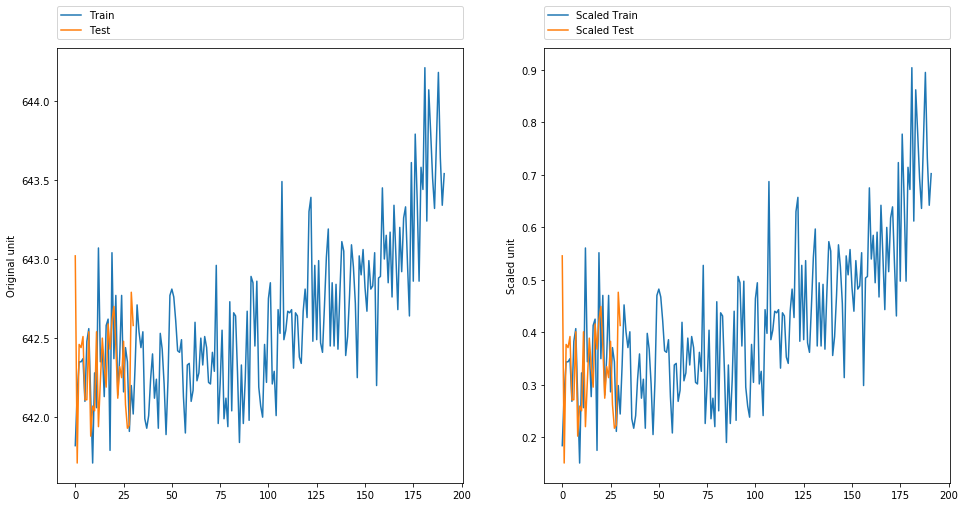

In [36]:
fig = plt.figure(figsize = (16, 8))
fig.add_subplot(1,2,1)
plt.plot(train[train.unit==1].s2)
plt.plot(test[test.unit==1].s2)
plt.legend(['Train','Test'], bbox_to_anchor=(0., 1.02, 1., .102), loc=3, mode="expand", borderaxespad=0)
plt.ylabel('Original unit')
fig.add_subplot(1,2,2)
plt.plot(ntrain[ntrain.unit==1].s2)
plt.plot(ntest[ntest.unit==1].s2)
plt.legend(['Scaled Train','Scaled Test'], bbox_to_anchor=(0., 1.02, 1., .102), loc=3, mode="expand", borderaxespad=0)
plt.ylabel('Scaled unit')
plt.show()

**12. Fraction time to failure**

Time to failure (TTF) for each unit has a different length, and it would be good to express this in a fraction of remaining number of cycles. This starts for a particular unit at 1.00, and goes to 0.00, the point where the engine fails (TTFx). It is in fact similar to scaling, but here it is applied at the unit level.

\begin{equation*}
fTTF_i = \frac{TTF_i - min(TTF)}{max(TTF) - min(TTF)}
\end{equation*}

In Python, we can express this in a function:

In [37]:
def fractionTTF(dat,q):
    return(dat.TTF[q]-dat.TTF.min()) / float(dat.TTF.max()-dat.TTF.min())

In [38]:
fTTFz = []
fTTF = []

for i in range(train['unit'].min(),train['unit'].max()+1):
    dat=train[train.unit==i]
    dat = dat.reset_index(drop=True)
    for q in range(len(dat)):
        fTTFz = fractionTTF(dat, q)
        fTTF.append(fTTFz)
ntrain['fTTF'] = fTTF

The following plot shows on the left TTF in cycles, for the first 4 units. On the right, the fraction TTF that starts at 1.00 and ends at 0.00. However, the number of cycles that it takes to failure remains identical. Some units have a longer duration than others, as can be clearly seen in the X-axes of the zigzag figures<font color="blue"><sup>5</sup></font>

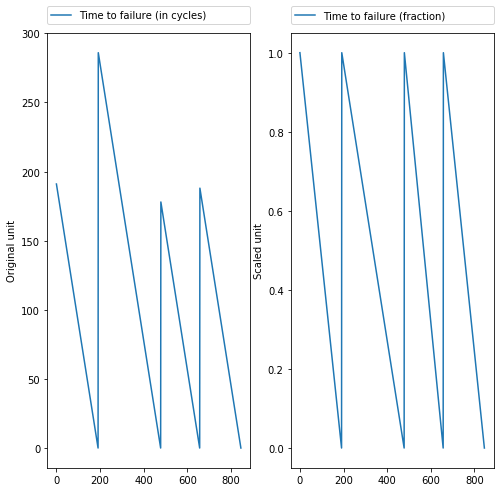

In [39]:
mx = cyclestrain.iloc[0:4,1].sum()

fig = plt.figure(figsize = (8, 8))
fig.add_subplot(1,2,1)
plt.plot(ntrain.TTF[0:mx])
plt.legend(['Time to failure (in cycles)'], bbox_to_anchor=(0., 1.02, 1., .102), loc=3, mode="expand", borderaxespad=0)
plt.ylabel('Original unit')
fig.add_subplot(1,2,2)
plt.plot(ntrain.fTTF[0:mx])
plt.legend(['Time to failure (fraction)'], bbox_to_anchor=(0., 1.02, 1., .102), loc=3, mode="expand", borderaxespad=0)
plt.ylabel('Scaled unit')
plt.show()

In [40]:
ntrain['fTTF'].describe()

count   20631.000
mean        0.500
std         0.290
min         0.000
25%         0.249
50%         0.500
75%         0.751
max         1.000
Name: fTTF, dtype: float64

Finally, we have the following columns that we select from for training the model.

In [41]:
pd.DataFrame(ntrain.columns).transpose()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,unit,cycles,op_setting1,op_setting2,s2,s3,s4,s6,s7,s8,...,s12,s13,s14,s15,s17,s20,s21,maxcycles,TTF,fTTF


** 13. Neural network in Keras**

We are now ready to train the data and predict the RUL. For this we are using Keras.
Importantly, for the target variable Y_train, we take the fraction of the time to failure TTFx. The features are the scaled values. Note that the data are in Numpy.ndarray format, which can be checked by **type(X_train)** 

In [42]:
X_train = ntrain.values[:,1:19]
Y_train = ntrain.values[:, 21]
X_test = ntest.values[:,1:19]

About the neural network in Keras: A ReLU activation function is used. We use the Adam optimizer.
The model is not optimized, and so probably still better results can be obtained by tuning the parameters. The neural network that we use here has 18 input neurons, 6 intermediate neurons, 1 output neuron (1 output since it is a regression problem, estimating the remaining useful lifetime).

Everything is ready to train the model:

In [43]:
model = Sequential()
model.add(Dense(6, input_dim=18, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])



W0907 10:02:38.355736 14468 deprecation_wrapper.py:119] From d:\python37\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0907 10:02:38.748953 14468 deprecation_wrapper.py:119] From d:\python37\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0907 10:02:38.880851 14468 deprecation_wrapper.py:119] From d:\python37\lib\site-packages\keras\backend\tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0907 10:02:39.005775 14468 deprecation_wrapper.py:119] From d:\python37\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [44]:
plot_model(model, to_file='model.png')

In [45]:
history = model.fit(X_train, Y_train, validation_split=0.25, epochs=50, batch_size=16, verbose=1)



W0907 10:02:39.906860 14468 deprecation_wrapper.py:119] From d:\python37\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0907 10:02:39.949035 14468 deprecation_wrapper.py:119] From d:\python37\lib\site-packages\keras\backend\tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 15473 samples, validate on 5158 samples
Epoch 1/50
15473/15473 [==============================] - 2s 146us/step - loss: 0.0434 - acc: 0.0092 - val_loss: 0.0135 - val_acc: 0.0091
Epoch 2/50
15473/15473 [==============================] - 1s 52us/step - loss: 0.0075 - acc: 0.0099 - val_loss: 0.0107 - val_acc: 0.0091
Epoch 3/50
15473/15473 [==============================] - 1s 50us/step - loss: 0.0063 - acc: 0.0099 - val_loss: 0.0098 - val_acc: 0.0091
Epoch 4/50
15473/15473 [==============================] - 1s 50us/step - loss: 0.0056 - acc: 0.0099 - val_loss: 0.0099 - val_acc: 0.0091
Epoch 5/50
15473/15473 [==============================] - 1s 49us/step - loss: 0.0050 - acc: 0.0099 - val_loss: 0.0144 - val_acc: 0.0091
Epoch 6/50
15473/15473 [==============================] - 1s 48us/step - loss: 0.0050 - acc: 0.0099 - val_loss: 0.0062 - val_acc: 0.0091
Epoch 7/50
15473/15473 [==============================] - 1s 52us/step - loss: 0.0047 - acc: 0.0099 - val_loss: 0.0074 - val_acc

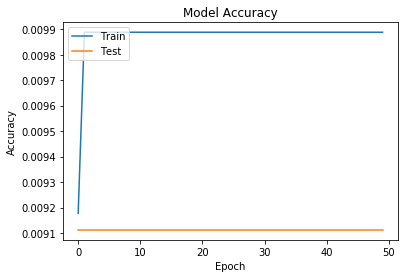

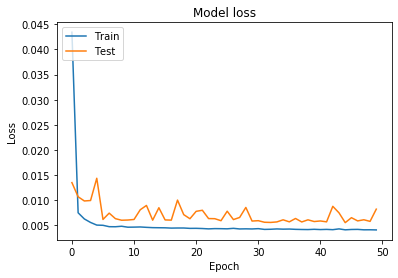

In [46]:
# Plot training & validation loss values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [47]:
plot_model(model, to_file='model.png')

**14. Predict test score, fraction RUL from 1.00-0.00**

We can now predict the fraction RUL values for the testset:

In [48]:
score = model.predict(X_test)

Remind that the values Y_train were before transformed to a fraction of remaining useful life, from 1.0 till 0.00, in order to cancel out the possible effect of total cycle duration. So *score* should also contain values in this range: 

In [49]:
score[0:10]

array([[1.028456 ],
       [1.0506425],
       [1.0389062],
       [1.0116196],
       [1.0261066],
       [1.0054942],
       [0.9965677],
       [0.9897945],
       [1.0152769],
       [0.9764635]], dtype=float32)

The values are roughly in the range 0-1:

In [50]:
print(score.min(), score.max())

0.03897441 1.0816997


Finally, we would like to re-convert the *fraction* of remaining life (0.00-1.00) to remaining useful life as expressed in *number of cycles*.

For this, we would first need a column with the maximum number of cycles per unit that were in the testset, which can be obtained by the **groupby** and **merge** functions (we did this before for the train set as well):

In [51]:
test = pd.merge(test, test.groupby('unit', as_index=False)['cycles'].max(), how='left', on='unit')

In [52]:
test.rename(columns={"cycles_x": "cycles", "cycles_y": "maxcycles"}, inplace=True)

In [53]:
test['score'] = score

In [54]:
test.head()

,unit,cycles,op_setting1,op_setting2,s2,s3,s4,s6,s7,s8,...,s11,s12,s13,s14,s15,s17,s20,s21,maxcycles,score
0,1,1,0.002,0.000,643.020,1585.290,1398.210,21.610,553.900,2388.040,...,47.200,521.720,2388.030,8125.550,8.405,392,38.860,23.373,31,1.028
1,1,2,-0.003,-0.000,641.710,1588.450,1395.420,21.610,554.850,2388.010,...,47.500,522.160,2388.060,8139.620,8.380,393,39.020,23.392,31,1.051
2,1,3,0.000,0.000,642.460,1586.940,1401.340,21.610,554.110,2388.050,...,47.500,521.970,2388.030,8130.100,8.444,393,39.080,23.417,31,1.039
3,1,4,0.004,0.000,642.440,1584.120,1406.420,21.610,554.070,2388.030,...,47.280,521.380,2388.050,8132.900,8.392,391,39.000,23.374,31,1.012
4,1,5,0.001,0.000,642.510,1587.190,1401.920,21.610,554.160,2388.010,...,47.310,522.150,2388.030,8129.540,8.403,390,38.990,23.413,31,1.026


Remind that "test" contains only the *unscaled* values, whereas for modeling and predicting "score" the *scaled* features were used.

Second, knowing the predicted remaining life (fraction), we need to estimate the predicted total number of cycles per unit in the testset. This can be done with the following function:

\begin{equation*}
max(predicted cycles_i) = \frac{cycles_i}{(1-predicted fTTF_i)}
\end{equation*}

In [55]:
def totcycles(data):
    return(data['cycles'] / (1-data['score']))
    
test['maxpredcycles'] = totcycles(test)

Last, we subtract the maximum cycles per unit from the predicted total number of cycles in the testset to obtain the RUL, remaining useful lifetime:

\begin{equation*}
RUL_i = max(predicted cycles_i) - max(cycles)
\end{equation*}

In [56]:
def RULfunction(data):
    return(data['maxpredcycles'] - data['maxcycles'])

test['RUL'] = RULfunction(test)

From this column RUL in the testdata we can reconstruct the remaining useful life at the point the maximum cycle is reached, in each unit:

In [57]:
test['RUL'].head()

0    -66.142
1    -70.493
2   -108.108
3   -375.247
4   -222.522
Name: RUL, dtype: float64

**15. Predict RUL in cycles**

The following will compute the RUL per unit (based on the max. cycles) from the RUL column that contains predicted values for each row.

In [58]:
t = test.columns == 'RUL'
ind = [i for i, x in enumerate(t) if x]

predictedRUL = []

for i in range(test.unit.min(), test.unit.max()+1):
    npredictedRUL=test[test.unit==i].iloc[test[test.unit==i].cycles.max()-1,ind]
    predictedRUL.append(npredictedRUL)
    
predictedRUL[0:10]

[RUL   156.354
 Name: 30, dtype: float64, RUL   118.858
 Name: 79, dtype: float64, RUL   48.519
 Name: 205, dtype: float64, RUL   63.066
 Name: 311, dtype: float64, RUL   75.824
 Name: 409, dtype: float64, RUL   81.338
 Name: 514, dtype: float64, RUL   82.157
 Name: 674, dtype: float64, RUL   50.963
 Name: 840, dtype: float64, RUL   105.610
 Name: 895, dtype: float64, RUL   70.364
 Name: 1087, dtype: float64]

In [59]:
len(predictedRUL)

100

We had the so-called "zigzag" figure for the trainset. Now we can re-construct and visualize this for the testset, for the predicted and true values. Let us first create a list of values that discounts for every RUL per unit:

In [60]:
xtrueRUL = list(RUL.loc[:,0])
otrueRUL = []

for i in range(0,len(xtrueRUL)):
    otrueRUL = np.concatenate((otrueRUL, list(reversed(np.arange(xtrueRUL[i])))))

In [61]:
xpredictedRUL = list(round(x) for x in predictedRUL)
opredictedRUL = []

for i in range(0,len(xpredictedRUL)):
    opredictedRUL = np.concatenate((opredictedRUL, list(reversed(np.arange(float(xpredictedRUL[i]))))))

In [62]:
opredictedRUL

array([155., 154., 153., ...,   2.,   1.,   0.])

The following figure shows the ZigZag pattern (first 1000 rows) for predicted and true RUL, and should show quite similar peak patterns:

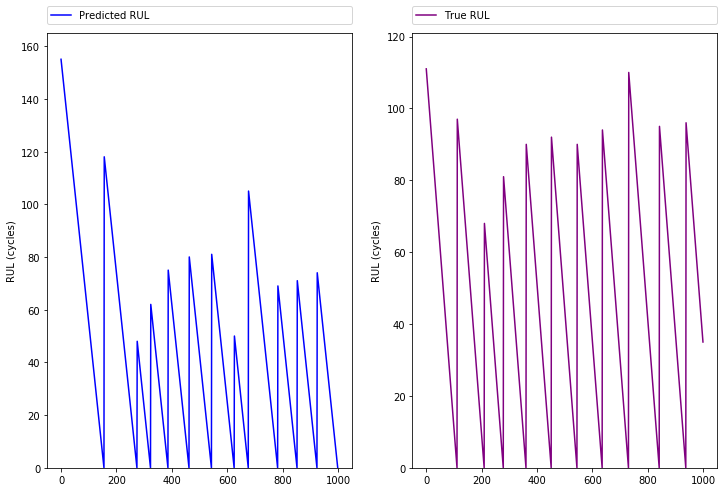

In [63]:
mx = 1000

fig = plt.figure(figsize = (12, 8))
fig.add_subplot(1,2,1)
plt.plot(opredictedRUL[0:mx], color='blue')
plt.legend(['Predicted RUL'], bbox_to_anchor=(0., 1.02, 1., .102), loc=3, mode="expand", borderaxespad=0)
plt.ylim(0, opredictedRUL[0:mx].max()+10)
plt.ylabel('RUL (cycles)')

fig.add_subplot(1,2,2)
plt.plot(otrueRUL[0:mx], color='purple')
plt.legend(['True RUL'], bbox_to_anchor=(0., 1.02, 1., .102), loc=3, mode="expand", borderaxespad=0)
plt.ylabel('RUL (cycles)')
plt.ylim(0,otrueRUL[0:mx].max()+10)
plt.show()

## 16. Comparison predicted and true RUL

We can compare the predicted with the true RUL values using the following lineplot. Actually a lineplot is strictly spoken not valid here, since there are no measures inbetween the units. But it is for visualization purposes: the eye catches quickly that the predicted RULs are often a bit higher than the true values.

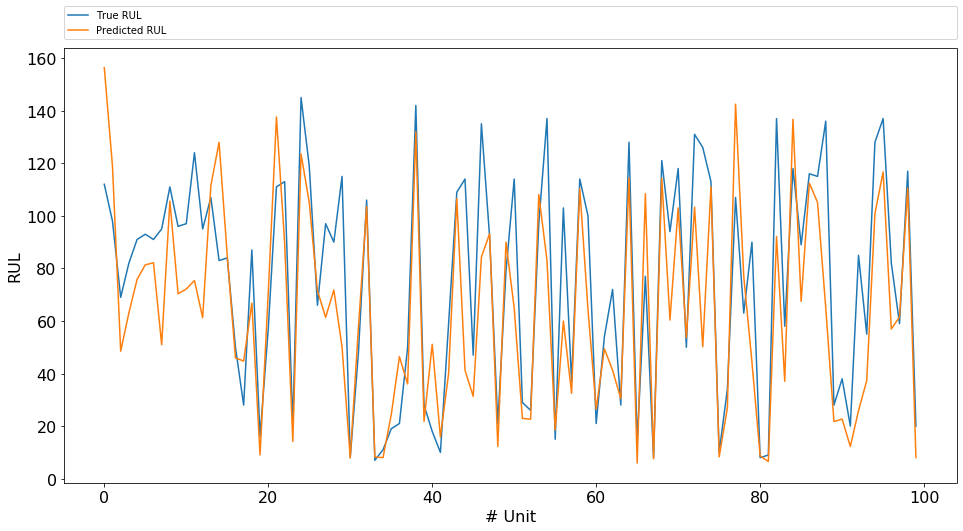

In [64]:
plt.figure(figsize = (16, 8))
plt.plot(RUL)
plt.plot(predictedRUL)
plt.xlabel('# Unit', fontsize=16)
plt.xticks(fontsize=16)
plt.ylabel('RUL', fontsize=16)
plt.yticks(fontsize=16)
plt.legend(['True RUL','Predicted RUL'], bbox_to_anchor=(0., 1.02, 1., .102), loc=3, mode="expand", borderaxespad=0)
plt.show()

Let us inspect the differences in a DataFrame. First we concatenate the true and predicted RUL:

In [65]:
df1 = pd.concat([pd.Series(RUL[0]), pd.Series(xpredictedRUL)], axis=1)
df1.columns = ['true', 'predicted']

And compute the difference score, which will show us if more values are positive or negative:

In [66]:
df1['diff'] = df1['predicted']-df1['true']

In [67]:
df1['diff'].astype(int)

0     44
1     21
2    -20
3    -19
4    -15
      ..
95   -20
96   -25
97     3
98    -6
99   -12
Name: diff, Length: 100, dtype: int32

In [68]:
xpredictedRUL[0:5]

[RUL   156.000
 Name: 30, dtype: float64, RUL   119.000
 Name: 79, dtype: float64, RUL   49.000
 Name: 205, dtype: float64, RUL   63.000
 Name: 311, dtype: float64, RUL   76.000
 Name: 409, dtype: float64]

In [69]:
df1.astype(int).head()

,true,predicted,diff
0,112,156,44
1,98,119,21
2,69,49,-20
3,82,63,-19
4,91,76,-15


There is a tendency for the RUL testvalues being overestimated, as we can see in the histogram:

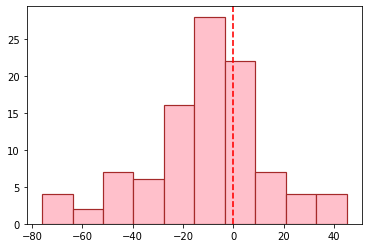

In [70]:
plt.hist(df1['diff'].astype(int), bins=10, color="pink", edgecolor='brown', linewidth=1.2)
plt.axvline(0, color="red", linestyle='dashed', linewidth=1.6)
plt.show()

And the below table confirms this as well:

In [71]:
pd.DataFrame({'Count': [(df1['diff'].astype(int)<0).sum(), (df1['diff'].astype(int)==0).sum(), (df1['diff'].astype(int)>0).sum()]}, columns=['Count'], index=['Smaller', 'Zero', 'Larger'])

,Count
Smaller,70
Zero,2
Larger,28


In many data science projects, slight overestimation is not a real problem. In the current case this can however be a risky business, with regards to the balance between maintenance costs and safety of aircrafts. 

**17. MSE**

Finally, we may like to express the obtained result in a performance metric. MSE is often used in regression problems.

\begin{equation*}
MSE \ RUL = \frac{1}{N} \sum_{i=1}^n (Predicted - True)^2
\end{equation*}

In [72]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(RUL, xpredictedRUL)
print (mse)

692.43


## Closing words 

So far the results are quite reasonable for a first model in Keras, not denying that a lot can still be improved. Comparing with previous data, the present results are in a MSE range reported by others<font color="blue"><sup>6</sup></font>. 
Several factors can still improve the result:

* Parameter tuning was not used and may give better results
* Cross-validation may control for overfitting
* Features may be improved by for example filtering out the noise
* It should be said that the chosen model may not be the best, other models may take into account the time-related aspects in the data (for example LSTM).

In addition, in a given project the performance metrics (MSE) may not be the main goal, insight into features that explain engine failure may be as important. That goal may be reached using algorithms that can give insight into *feature importance* such as random forest. 

**See you next time!**

Hope you liked this blog. If you have any questions, suggestions, or see any errors, please contact me: <font color="blue">rrighart@googlemail.com</font>.

**Notes & References**

1. A. Saxena and K. Goebel (2008). "Turbofan Engine Degradation Simulation Data Set", NASA Ames Prognostics Data Repository (http://ti.arc.nasa.gov/project/prognostic-data-repository), NASA Ames Research Center, Moffett Field, CA

2. Windturbines. https://www.greentechmedia.com/articles/read/big-data-is-boosting-power-production-reducing-downtime-across-wind-fleets

3. A. Qin et al. (2017). Remaining useful life prediction for rotating machinery based on optimal degradation indicator. https://www.hindawi.com/journals/sv/2017/6754968/

4. Download a zip file. https://stackoverflow.com/questions/9419162/python-download-returned-zip-file-from-url

5. The name ZigZag should not be confused with the package "ZigZag" that is used to compute peaks in time-series. https://github.com/jbn/ZigZag/blob/master/zigzag_demo.ipynb

6. Jain, Kundu, Kumar Lad (2014). Prediction of remaining useful life of an aircraft engine under unknown initial wear. AIMTDR 2014.

--------------------------------------------------------------------------------------------------------------------------------------------

(c) 2018, R. Righart | Website: https://rrighart.github.io | Email: <font color="blue">rrighart@googlemail.com</font>

Acknowledgements for CSS style go to jckantor